<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/CNN_Sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Environment Setup

import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import transforms
from IPython.display import display, HTML

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 230)

# Seed settings
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the directory and file paths
raw_image_path = '/content/US_Pictures/US_Pictures/'
image_path = '/content/US_Pictures/US_Pictures/Preprocessed/'
zip_path = '/content/US_Pictures.zip'

# Check if the raw image directory already contains data
if not os.path.exists(raw_image_path):
    os.makedirs(raw_image_path)
    print("Raw image directory created.")

# Check if the preprocessed image directory already contains data
if not os.path.exists(image_path):
    os.makedirs(image_path)
    print("Preprocessed image directory created.")

# Check if the data needs to be downloaded
if not os.listdir(raw_image_path) or not any(f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) for f in os.listdir(raw_image_path)):
    print("Downloading data...")
    !wget -O {zip_path} https://zenodo.org/records/7669442/files/US_Pictures.zip
    !unzip -q {zip_path} -d /content/US_Pictures/
else:
    print("Data already downloaded.")

# List the contents of the raw image directory
print(os.listdir(raw_image_path))



Preprocessed image directory created.
--2024-05-14 02:24:07--  https://zenodo.org/records/7669442/files/US_Pictures.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 523034730 (499M) [application/octet-stream]
Saving to: ‘/content/US_Pictures.zip’

/content/US_Picture 100%[===================>] 498.80M  15.3MB/s    in 35s     

2024-05-14 02:24:43 (14.3 MB/s) - ‘/content/US_Pictures.zip’ saved [523034730/523034730]

['334.2 App_M.bmp', '870.1 App_M.bmp', '94.4 App_M.bmp', '680.1 RLQ app not visible.bmp', '537.5 App.bmp', '827.5 App_M.bmp', '879.1 App_M.bmp', '602.2 App.bmp', '872.1 App.bmp', '168.7 App.bmp', '51.3 App.bmp', '918.1 App_M.bmp', '547.9 App.bmp', '499.3 App.bmp', '107.4 App_M.bmp', '695.3 App.bmp', '927.7 App_M.bmp', '490.4 App.bmp', '496.1 App_M.bmp', '125.4 App_M.bmp', '458.2 App.bmp', '924.3 App_M.bmp'

In [3]:
# # Reset Image Path
# import os
# import shutil

# def reset_directory(path):
#     # Check if the directory exists
#     if os.path.exists(path):
#         # If the directory exists, remove it along with all its contents
#         shutil.rmtree(path)
#         print(f"Deleted the directory: {path}")

#     # Recreate the directory
#     os.makedirs(path)
#     print(f"Recreated the directory: {path}")

# # Define the image path
# image_path = '/content/US_Pictures/US_Pictures/'

# # Call the function to reset the directory
# reset_directory(image_path)

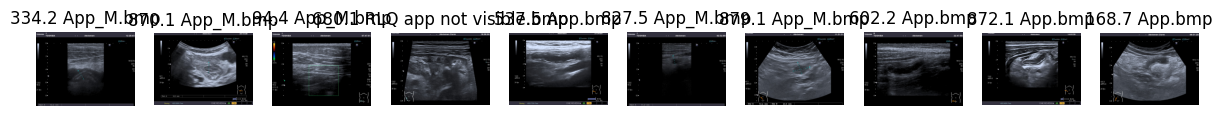

In [4]:
# Display First Five Images
def display_images(image_path):
    files = [f for f in os.listdir(image_path) if f.endswith(('.png', '.bmp'))][:10]
    if not files:
        print("No image files found in the directory.")
        return
    fig, axs = plt.subplots(1, 10, figsize=(15, 5))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(image_path, file))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(file)
    plt.show()

# Call the function with the path to the images
display_images(raw_image_path)


In [5]:
# Load data from the URL
data_url = "https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv"
data = pd.read_csv(data_url, delimiter=';')

# Drop unnecessary variables from the dataset
columns_to_drop = [
    'Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management', 'Severity',
    'Diagnosis_Presumptive', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
    'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness',
    'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage',
    'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
    'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis',
    'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers',
    'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
    'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening',
    'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings'
] + [f'Unnamed: {i}' for i in range(58, 69)]
data.drop(columns=columns_to_drop, inplace=True)

# Map 'Diagnosis' to binary values and handle missing values
data['Diagnosis'].replace({'appendicitis': 1, 'no appendicitis': 0, np.nan: 0}, inplace=True)

# Remove rows with NaN in 'US_Number' and convert columns to integer
data.dropna(subset=['US_Number'], inplace=True)
data['US_Number'] = data['US_Number'].astype(int)
data['Diagnosis'] = data['Diagnosis'].astype(int)

# Create a dictionary mapping 'US_Number' to 'Diagnosis'
id_to_label = {int(row['US_Number']): row['Diagnosis'] for index, row in data.iterrows()}
print(id_to_label)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def process_and_save_images(root_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(root_dir):
        file_path = os.path.join(root_dir, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with Image.open(file_path).convert('RGB') as img:
                    transformed_tensor = transform(img)
                    transformed_img = TF.to_pil_image(transformed_tensor)
                    output_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
                    transformed_img.save(output_file_path, format='PNG')
            except Exception as e:
                print(f"Failed to process {filename}: {str(e)}")

# Usage
process_and_save_images(raw_image_path, image_path)


{882: 1, 883: 0, 884: 0, 886: 0, 887: 1, 888: 0, 889: 0, 890: 0, 891: 0, 893: 1, 894: 1, 895: 0, 896: 0, 897: 0, 900: 1, 903: 0, 904: 1, 905: 1, 909: 1, 910: 0, 911: 1, 913: 0, 914: 0, 916: 0, 917: 0, 918: 1, 921: 1, 922: 0, 924: 1, 925: 1, 926: 0, 927: 1, 928: 1, 929: 0, 930: 1, 931: 0, 933: 1, 934: 0, 935: 1, 936: 1, 938: 1, 939: 1, 940: 0, 942: 0, 943: 0, 945: 0, 946: 0, 947: 1, 948: 0, 949: 0, 950: 1, 951: 0, 952: 0, 953: 1, 954: 0, 955: 1, 959: 0, 961: 0, 962: 0, 963: 0, 965: 1, 967: 0, 968: 0, 971: 0, 973: 1, 974: 1, 976: 0, 977: 0, 978: 0, 981: 1, 982: 0, 983: 0, 986: 0, 988: 0, 989: 1, 991: 0, 992: 1, 733: 1, 735: 1, 736: 0, 737: 0, 738: 1, 739: 0, 740: 1, 743: 0, 745: 0, 746: 1, 748: 1, 749: 1, 750: 1, 751: 1, 752: 1, 753: 0, 754: 0, 755: 0, 756: 1, 757: 0, 759: 1, 760: 0, 761: 1, 765: 0, 769: 0, 771: 1, 772: 1, 775: 1, 777: 1, 779: 0, 780: 0, 781: 1, 782: 0, 786: 0, 787: 0, 789: 0, 790: 1, 791: 1, 794: 0, 795: 0, 796: 0, 797: 1, 799: 0, 801: 1, 802: 1, 803: 0, 804: 0, 805: 0,

In [6]:
class MedicalImagesDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None, augment=False):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.augment = augment
        self.filename_mapping = {}
        self.unique_us_numbers = set()
        self.diagnosis_count_per_image = defaultdict(int)
        self.augmented_count_per_image = defaultdict(int)
        self.num_images_found = 0
        table_data = []

        for filename in os.listdir(root_dir):
            self.num_images_found += 1
            base_name = filename.split(' ')[0]
            match = re.match(r"([0-9]+(?:\.[0-9]+)?)", base_name)
            if match:
                image_number = int(match.group(1).split('.')[0])
                label = labels_dict.get(image_number)
                if label is not None:
                    self.unique_us_numbers.add(image_number)
                    self.diagnosis_count_per_image[label] += 1
                    image_path = os.path.join(root_dir, filename)
                    image = Image.open(image_path).convert('RGB')
                    if self.transform:
                        processed_image = self.transform(image)
                    else:
                        processed_image = image
                    self.filename_mapping[filename] = (processed_image, label)
                    table_data.append((image_number, filename, label, type(image_number)))

                    if self.augment and label == 0:
                        augmented_images = self.augment_image(image, 2, filename)
                        for aug_filename, aug_image in augmented_images.items():
                            self.filename_mapping[aug_filename] = (aug_image, label)
                            self.augmented_count_per_image[label] += 1

    def augment_image(self, image, times, original_filename):
        possible_transformations = [
            lambda x: TF.rotate(x, -10),
            lambda x: TF.rotate(x, -5),
            lambda x: TF.rotate(x, 5),
            lambda x: TF.rotate(x, 10),
            lambda x: TF.affine(x, translate=(0.1, 0.1), scale=1.05, angle=0, shear=0),
            lambda x: TF.affine(x, translate=(0.1, 0.1), scale=1.1, angle=0, shear=0),
            lambda x: TF.affine(x, translate=(-0.1, -0.1), scale=0.95, angle=0, shear=0),
            lambda x: TF.affine(x, translate=(-0.1, -0.1), scale=0.9, angle=0, shear=0),
            lambda x: TF.affine(x, angle=0, translate=(0, 0), scale=1.0, shear=5)
        ]
        selected_transforms = random.sample(possible_transformations, min(len(possible_transformations), times))
        augmented_images = {}
        for i, transform in enumerate(selected_transforms):
            aug_image = transform(image)
            if self.transform:
                aug_image = self.transform(aug_image)
            augmented_images[f"{original_filename}_{i+1}"] = aug_image
        return augmented_images

    def __len__(self):
        return len(self.filename_mapping)

    def __getitem__(self, idx):
        filename = list(self.filename_mapping.keys())[idx]
        image, label = self.filename_mapping[filename]
        return image, label, filename

    def print_dataset_statistics(self):
        print(f"Total images found before matching: {self.num_images_found}")
        print(f"Total US numbers successfully mapped to images: {len(self.unique_us_numbers)}")
        print(f"Total images successfully mapped to a US_NUMBER: {len(self.filename_mapping)}")
        print(f"Original images: {sum(self.diagnosis_count_per_image.values())}")
        print(f"Augmented images: {sum(self.augmented_count_per_image.values())}")
        for label, count in self.diagnosis_count_per_image.items():
            aug_count = self.augmented_count_per_image[label]
            total_count = count + aug_count
            ratio = aug_count / float(count) if count != 0 else 0
            print(f"Label {label}: Original {count}, Augmented {aug_count}, Total {total_count}, Ratio {ratio:.2f}")

# nitialize the dataset with the specified directory, label mappings, transformations, and augmentation enabled.
dataset = MedicalImagesDataset(image_path, id_to_label, transform, augment=True)

# Print first entries of the dataset to inspect their structure
for idx in range(10):
    image, label, filename = dataset[idx]
    print(f"Filename: {filename}, Label: {label}, Image Tensor Shape: {image.shape}")


Filename: 751.4 App.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 205.3 App_M.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 350.1 App_D.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 143.1 App.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 587.5 App.png, Label: 0, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 587.5 App.png_1, Label: 0, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 587.5 App.png_2, Label: 0, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 105.4 App_M.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 67.2 App L.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])
Filename: 56.1 RLQ min. FF_App not visible.png, Label: 1, Image Tensor Shape: torch.Size([3, 256, 256])


In [7]:
# Print first entries of the dataset to inspect their structure
for idx in range(1):
    print(dataset[idx])

(tensor([[[ 1.2214,  1.2214,  1.2214,  ...,  1.2214,  1.2214,  1.2214],
         [ 1.2214,  1.2214,  1.2214,  ...,  1.2214,  1.2214,  1.2214],
         [ 1.2214,  1.2214,  1.2214,  ...,  1.2214,  1.2214,  1.2214],
         ...,
         [ 1.3070,  1.3070,  1.3070,  ..., -1.1418,  1.3755,  1.3070],
         [ 1.3070,  1.3070,  1.3070,  ...,  1.5982,  1.2214,  1.3070],
         [ 1.3070,  1.3070,  1.3070,  ...,  1.3070,  1.3070,  1.2214]],

        [[ 1.6758,  1.6758,  1.6758,  ...,  1.6758,  1.6758,  1.6758],
         [ 1.6758,  1.6758,  1.6758,  ...,  1.6758,  1.6758,  1.6758],
         [ 1.6758,  1.6758,  1.6758,  ...,  1.6758,  1.6758,  1.6758],
         ...,
         [ 1.7633,  1.7633,  1.7633,  ..., -0.6176,  1.8333,  1.6758],
         [ 1.7633,  1.7633,  1.7633,  ...,  2.0609,  1.6758,  1.6758],
         [ 1.7633,  1.7633,  1.7633,  ...,  1.7633,  1.7633,  1.6758]],

        [[-0.4798, -0.4798, -0.4798,  ..., -0.4798, -0.4798, -0.4798],
         [-0.4798, -0.4798, -0.4798,  ..., -

In [8]:
# Initialize a dictionary to count images per US_NUMBER
image_counts = defaultdict(int)

# Collect initial image counts
for filename in dataset.filename_mapping:
    try:
        us_number = int(filename.split('.')[0])
        image_counts[us_number] += 1
    except ValueError as e:
        print(f"Skipping filename with parsing issue: {filename}. Error: {e}")

# Threshold for reassignment
threshold = 10
reassigned_filenames = {}
reassigned_labels = {}

# Collect keys to iterate over to prevent runtime error due to dictionary size change
us_numbers_to_process = [us_number for us_number, count in image_counts.items() if count > threshold]

# Reassigning process with dynamic suffix management
for us_number in us_numbers_to_process:
    suffix_files = defaultdict(list)
    for filename in list(dataset.filename_mapping):
        if int(filename.split('.')[0]) == us_number and '_' in filename:
            parts = filename.split('_')[1]
            if parts[0].isdigit():
                suffix = int(parts[0])
                suffix_files[suffix].append(filename)

    # Assign new us_number for each suffix
    for suffix, files in suffix_files.items():
        new_us_number = (suffix + 1) * 1000 + us_number  # Create a new us_number based on suffix
        for filename in files:
            new_filename = filename.replace(str(us_number), str(new_us_number))
            reassigned_filenames[new_filename] = dataset.filename_mapping.pop(filename)
            original_label = dataset.labels_dict.get(us_number, "Unknown label")
            reassigned_labels[new_filename] = original_label
            dataset.labels_dict[new_us_number] = original_label
            image_counts[new_us_number] += 1

# Update the dataset with new mappings
dataset.filename_mapping.update(reassigned_filenames)

# Recalculate counts and prepare for output
new_image_counts = defaultdict(int)
for filename in dataset.filename_mapping:
    try:
        us_number = int(filename.split('.')[0])
        new_image_counts[us_number] += 1
    except ValueError as e:
        print(f"Skipping filename with parsing issue: {filename}. Error: {e}")

# Prepare data for tabulation
table_data = [
    [us_number, image_counts[us_number], new_image_counts[us_number], dataset.labels_dict.get(us_number)]
    for us_number in sorted(new_image_counts)
]

# Split table_data into parts for display
split_size = len(table_data) // 4
parts = [table_data[i * split_size: (i + 1) * split_size] for i in range(4)]

# Helper function to convert data to HTML table with borders
def data_to_html_table(data):
    html = '<table style="width: 100%; border-collapse: collapse;">'
    html += '<tr style="border: 1px solid black;">' \
            '<th style="border: 1px solid black;">US_NUMBER</th>' \
            '<th style="border: 1px solid black;">Old Count</th>' \
            '<th style="border: 1px solid black;">New Count</th>' \
            '<th style="border: 1px solid black;">Label</th></tr>'
    for row in data:
        html += '<tr>' + ''.join(f'<td style="border: 1px solid black;">{cell}</td>' for cell in row) + '</tr>'
    html += '</table>'
    return html

# Display the parts side by side using HTML and CSS
display(HTML(f'''
<div style="display: flex; justify-content: center; width: 100%;">
    {''.join(f'<div style="flex: 1; padding: 5px;"><b>Part {i + 1}:</b><br>{data_to_html_table(parts[i])}</div>' for i in range(4))}
</div>
'''))

# Print the count of pictures in the original filename mapping after augmentation
print("Count of pictures in original filename_mapping after augmentation:", len(dataset.filename_mapping))

# Function to count unique US numbers
def count_us_numbers(filename_mapping):
    us_numbers = set()
    for filename in filename_mapping:
        try:
            us_number = int(filename.split('.')[0])
            us_numbers.add(us_number)
        except ValueError:
            continue  # Skip filenames that do not start with an integer
    return len(us_numbers)

# Calculate unique US number counts after processing
final_original_us_numbers_count = count_us_numbers(dataset.filename_mapping)

# Print the final counts
print("Final count of unique US numbers in original filename_mapping after augmentation:", final_original_us_numbers_count)

US_NUMBER,Old Count,New Count,Label
1,18,8,0
3,18,8,0
4,2,2,1
5,9,9,0
6,4,4,1
7,3,3,0
9,3,3,1
10,2,2,1
11,2,2,1
12,2,2,1


Count of pictures in original filename_mapping after augmentation: 2503
Final count of unique US numbers in original filename_mapping after augmentation: 621


In [9]:
# Print the count of pictures in the original filename mapping after augmentation
print("Count of pictures in original filename_mapping after augmentation:", len(dataset.filename_mapping))

# Function to count unique US numbers
def count_us_numbers(filename_mapping):
    us_numbers = set()
    for filename in filename_mapping:
        try:
            us_number = int(filename.split('.')[0])
            us_numbers.add(us_number)
        except ValueError:
            continue  # Skip filenames that do not start with an integer
    return len(us_numbers)

# Calculate unique US number counts after processing
final_original_us_numbers_count = count_us_numbers(dataset.filename_mapping)

# Print the final counts
print("Final count of unique US numbers in filename_mapping after augmentation:", final_original_us_numbers_count)

Count of pictures in original filename_mapping after augmentation: 2503
Final count of unique US numbers in filename_mapping after augmentation: 621


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import random
import re

# Definition der Collate-Funktion
def pad_sequence(sequences):
    # Find the maximum sequence length
    max_len = max([seq.size(0) for seq in sequences])
    batch_size, c, h, w = sequences[0].size(0), sequences[0].size(1), sequences[0].size(2), sequences[0].size(3)

    # Initialize a tensor with zeros to pad shorter sequences
    padded_sequences = torch.zeros(len(sequences), max_len, c, h, w)

    # Fill the tensor with the sequences
    for i, seq in enumerate(sequences):
        padded_sequences[i, :seq.size(0)] = seq

    return padded_sequences

def custom_collate_fn(batch):
    images, labels, patient_ids = zip(*batch)
    padded_images = pad_sequence(images)
    labels = torch.tensor(labels)
    patient_ids = torch.tensor(patient_ids)
    return padded_images, labels, patient_ids

# Definition der PatientDataset-Klasse
class PatientDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.patient_data = defaultdict(list)

        for img, label, filename in dataset:
            patient_id = int(filename.split('.')[0])
            self.patient_data[patient_id].append((img, label, filename))

        self.patient_ids = list(self.patient_data.keys())

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_images = [x[0] for x in self.patient_data[patient_id]]
        patient_label = self.patient_data[patient_id][0][1]
        patient_images = torch.stack(patient_images)
        return patient_images, patient_label, patient_id

# Erstellen der PatientDataset-Instanz
patient_dataset = PatientDataset(dataset)

In [11]:
# Print first entries of the dataset to inspect their structure
for idx in range(5):
    print(patient_dataset[idx])

(tensor([[[[ 1.2214,  1.2214,  1.2214,  ...,  1.2214,  1.2214,  1.2214],
          [ 1.2214,  1.2214,  1.2214,  ...,  1.2214,  1.2214,  1.2214],
          [ 1.2214,  1.2214,  1.2214,  ...,  1.2214,  1.2214,  1.2214],
          ...,
          [ 1.3070,  1.3070,  1.3070,  ..., -1.1418,  1.3755,  1.3070],
          [ 1.3070,  1.3070,  1.3070,  ...,  1.5982,  1.2214,  1.3070],
          [ 1.3070,  1.3070,  1.3070,  ...,  1.3070,  1.3070,  1.2214]],

         [[ 1.6758,  1.6758,  1.6758,  ...,  1.6758,  1.6758,  1.6758],
          [ 1.6758,  1.6758,  1.6758,  ...,  1.6758,  1.6758,  1.6758],
          [ 1.6758,  1.6758,  1.6758,  ...,  1.6758,  1.6758,  1.6758],
          ...,
          [ 1.7633,  1.7633,  1.7633,  ..., -0.6176,  1.8333,  1.6758],
          [ 1.7633,  1.7633,  1.7633,  ...,  2.0609,  1.6758,  1.6758],
          [ 1.7633,  1.7633,  1.7633,  ...,  1.7633,  1.7633,  1.6758]],

         [[-0.4798, -0.4798, -0.4798,  ..., -0.4798, -0.4798, -0.4798],
          [-0.4798, -0.4798, 

In [12]:
# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(patient_dataset))
val_size = int(0.15 * len(patient_dataset))
test_size = len(patient_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(patient_dataset, [train_size, val_size, test_size])

# Create dataloaders with the custom collate function
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# Definition des CNN-Modells
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_images, c, h, w = x.size()
        x = x.view(batch_size * num_images, c, h, w)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, num_images, -1)
        x = torch.mean(x, dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# # Training- und Validierungsprozess definieren
# def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         train_preds, train_labels = [], []

#         for images, labels, patient_ids in train_loader:  # Hier patient_ids hinzufügen
#             optimizer.zero_grad()
#             outputs = model(images)
#             labels = labels.float().view(-1, 1)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             train_preds.extend(outputs.detach().cpu().numpy())
#             train_labels.extend(labels.detach().cpu().numpy())

#         train_loss /= len(train_loader)
#         train_acc = accuracy_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
#         train_roc_auc = roc_auc_score(train_labels, train_preds)

#         model.eval()
#         val_preds, val_labels = [], []
#         with torch.no_grad():
#             for images, labels, patient_ids in val_loader:  # Hier patient_ids hinzufügen
#                 outputs = model(images)
#                 val_preds.extend(outputs.detach().cpu().numpy())
#                 val_labels.extend(labels.detach().cpu().numpy())

#         val_acc = accuracy_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
#         val_roc_auc = roc_auc_score(val_labels, val_preds)

#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC AUC: {train_roc_auc:.4f}")
#         print(f"Val Acc: {val_acc:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

# # Train the model
# train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5)


In [14]:
# # Testen des Modells auf den Testdaten
# def test_model(model, test_loader):
#     model.eval()
#     test_preds, test_labels = [], []
#     with torch.no_grad():
#         for images, labels, patient_ids in test_loader:  # Hier patient_ids hinzufügen
#             outputs = model(images)
#             test_preds.extend(outputs.detach().cpu().numpy())
#             test_labels.extend(labels.detach().cpu().numpy())

#     test_acc = accuracy_score(test_labels, (np.array(test_preds) > 0.5).astype(int))
#     test_roc_auc = roc_auc_score(test_labels, test_preds)

#     print(f"Test Acc: {test_acc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

# # Test the model
# test_model(model, test_loader)


In [15]:
import torch

# Training- und Validierungsprozess definieren
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, model_path='model.pth'):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels, patient_ids in train_loader:  # Hier patient_ids hinzufügen
            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
        train_roc_auc = roc_auc_score(train_labels, train_preds)

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels, patient_ids in val_loader:  # Hier patient_ids hinzufügen
                outputs = model(images)
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        val_acc = accuracy_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
        val_roc_auc = roc_auc_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC AUC: {train_roc_auc:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

        # Save the model checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_roc_auc': train_roc_auc,
            'val_acc': val_acc,
            'val_roc_auc': val_roc_auc,
        }, model_path)

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, model_path='model.pth')

# Testen des Modells auf den Testdaten
def test_model(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels, patient_ids in test_loader:  # Hier patient_ids hinzufügen
            outputs = model(images)
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.detach().cpu().numpy())

    test_acc = accuracy_score(test_labels, (np.array(test_preds) > 0.5).astype(int))
    test_roc_auc = roc_auc_score(test_labels, test_preds)

    print(f"Test Acc: {test_acc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

# Test the model
test_model(model, test_loader)


Epoch 1/5
Train Loss: 0.5369, Train Acc: 0.9395, Train ROC AUC: 0.9664
Val Acc: 0.9892, Val ROC AUC: 0.9743
Epoch 2/5
Train Loss: 0.0746, Train Acc: 0.9859, Train ROC AUC: 0.9900
Val Acc: 0.9892, Val ROC AUC: 0.9743
Epoch 3/5
Train Loss: 0.0873, Train Acc: 0.9839, Train ROC AUC: 0.9906
Val Acc: 0.9892, Val ROC AUC: 0.9753
Epoch 4/5
Train Loss: 0.0323, Train Acc: 0.9919, Train ROC AUC: 0.9987
Val Acc: 0.9785, Val ROC AUC: 0.9766
Epoch 5/5
Train Loss: 0.0254, Train Acc: 0.9960, Train ROC AUC: 0.9988
Val Acc: 0.9677, Val ROC AUC: 0.9786
Test Acc: 0.9375, Test ROC AUC: 1.0000


In [16]:
# Load the model
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
train_roc_auc = checkpoint['train_roc_auc']
val_acc = checkpoint['val_acc']
val_roc_auc = checkpoint['val_roc_auc']

model.eval()  # or model.train() if you want to resume training


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
def evaluate_model_on_testset_with_patient_ids(model, test_loader):
    model.eval()
    results = []

    with torch.no_grad():
        for images, labels, patient_ids in test_loader:
            outputs = model(images)
            predicted_labels = (outputs.detach().cpu().numpy() > 0.5).astype(int)
            true_labels = labels.detach().cpu().numpy()
            patient_ids = patient_ids.detach().cpu().numpy()

            for i in range(len(true_labels)):
                true_label = true_labels[i]
                predicted_label = predicted_labels[i][0]
                patient_id = patient_ids[i]
                results.append((patient_id, true_label, predicted_label))

    # Print the results
    for patient_id, true_label, predicted_label in results:
        print(f"Patient ID: {patient_id}, True Label: {true_label}, Predicted Label: {predicted_label}")

# Create dataloader for testing with batch size of 1 to preserve individual file information
test_loader_with_patient_ids = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

# Test the model and print the results
evaluate_model_on_testset_with_patient_ids(model, test_loader_with_patient_ids)

Patient ID: 324, True Label: 0, Predicted Label: 0
Patient ID: 18, True Label: 1, Predicted Label: 1
Patient ID: 327, True Label: 0, Predicted Label: 0
Patient ID: 6, True Label: 1, Predicted Label: 0
Patient ID: 613, True Label: 0, Predicted Label: 0
Patient ID: 450, True Label: 1, Predicted Label: 1
Patient ID: 943, True Label: 0, Predicted Label: 0
Patient ID: 56, True Label: 1, Predicted Label: 1
Patient ID: 615, True Label: 0, Predicted Label: 0
Patient ID: 122, True Label: 1, Predicted Label: 1
Patient ID: 123, True Label: 1, Predicted Label: 1
Patient ID: 64, True Label: 1, Predicted Label: 1
Patient ID: 370, True Label: 0, Predicted Label: 0
Patient ID: 449, True Label: 1, Predicted Label: 1
Patient ID: 808, True Label: 1, Predicted Label: 1
Patient ID: 1, True Label: 0, Predicted Label: 0
Patient ID: 570, True Label: 1, Predicted Label: 1
Patient ID: 81, True Label: 1, Predicted Label: 1
Patient ID: 446, True Label: 1, Predicted Label: 1
Patient ID: 746, True Label: 1, Predict